In [1]:
import SIMSIToolBox
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error
import random as rd
import seaborn as sb
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy import spatial
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.svm import SVR
cosineSim = lambda x1,x2: 1 - spatial.distance.cosine(x1, x2)
import statsmodels.api as sm
from scipy.interpolate import interp1d

In [12]:
#goal simulate labeling patterns

n=5
c13ab = 0.011 #natural abundance
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2] #get expected labeling of precursor from natural abundance
isa_func = SIMSIToolBox.palmitateISA

gs = np.random.random(n)
ds = np.random.random(n)
ts = np.random.random((n,3))
ts = np.array([x/np.sum(x) for x in ts])

In [13]:
labeling_theo = []
for g,t,d in zip(gs,ts,ds):
    labeling_theo.append(isa_func(g,d,t,N,None))
labeling_theo = np.array(labeling_theo)
T = [0,0,1]

In [14]:
plt_dict = {}

for noiseFrac in np.linspace(0,.5,100):

    for g,d,t,l_true in zip(gs,ds,ts,labeling_theo):
        iso = rd.choice(list(range(len(l_true))))
        l_obs = [x for x in l_true]
        l_obs[iso] += noiseFrac
        l_obs = np.array(l_obs)/np.sum(l_obs)

        err_measure = noiseFrac
        
        g_pred, _, x_pred, err, l_pred = SIMSIToolBox.ISAFit(T,N,l_obs,isa_func,list(range(len(l_obs))),.5)
        g_class, _, _, err, l_pred = SIMSIToolBox.ISAFit_classical(t,N,l_obs,isa_func,list(range(len(l_obs))),np.array([.5,.5]))

        if g_pred > -.0001 and g_pred < 1.1 and all(xx > -0.01 and xx < 1.1 for xx in x_pred) and g_class > -.0001 and g_class < 1.1:
            plt_dict[len(plt_dict)] = {"method":"SISA","error in g(t)":np.abs(g-g_pred),"measurement error":err_measure}
            plt_dict[len(plt_dict)] = {"method":"Classical ISA","error in g(t)":np.abs(g-g_class),"measurement error":err_measure}
plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
plt_dict

,method,error in g(t),measurement error
0,SISA,1.048913e-05,0.000000
1,Classical ISA,2.123412e-07,0.000000
2,SISA,1.511865e-05,0.000000
3,Classical ISA,2.421515e-06,0.000000
4,SISA,1.656074e-05,0.000000
...,...,...,...
641,Classical ISA,2.383291e-01,0.489899
642,SISA,4.589520e-02,0.494949
643,Classical ISA,4.222211e-02,0.494949
644,SISA,1.615191e-01,0.500000


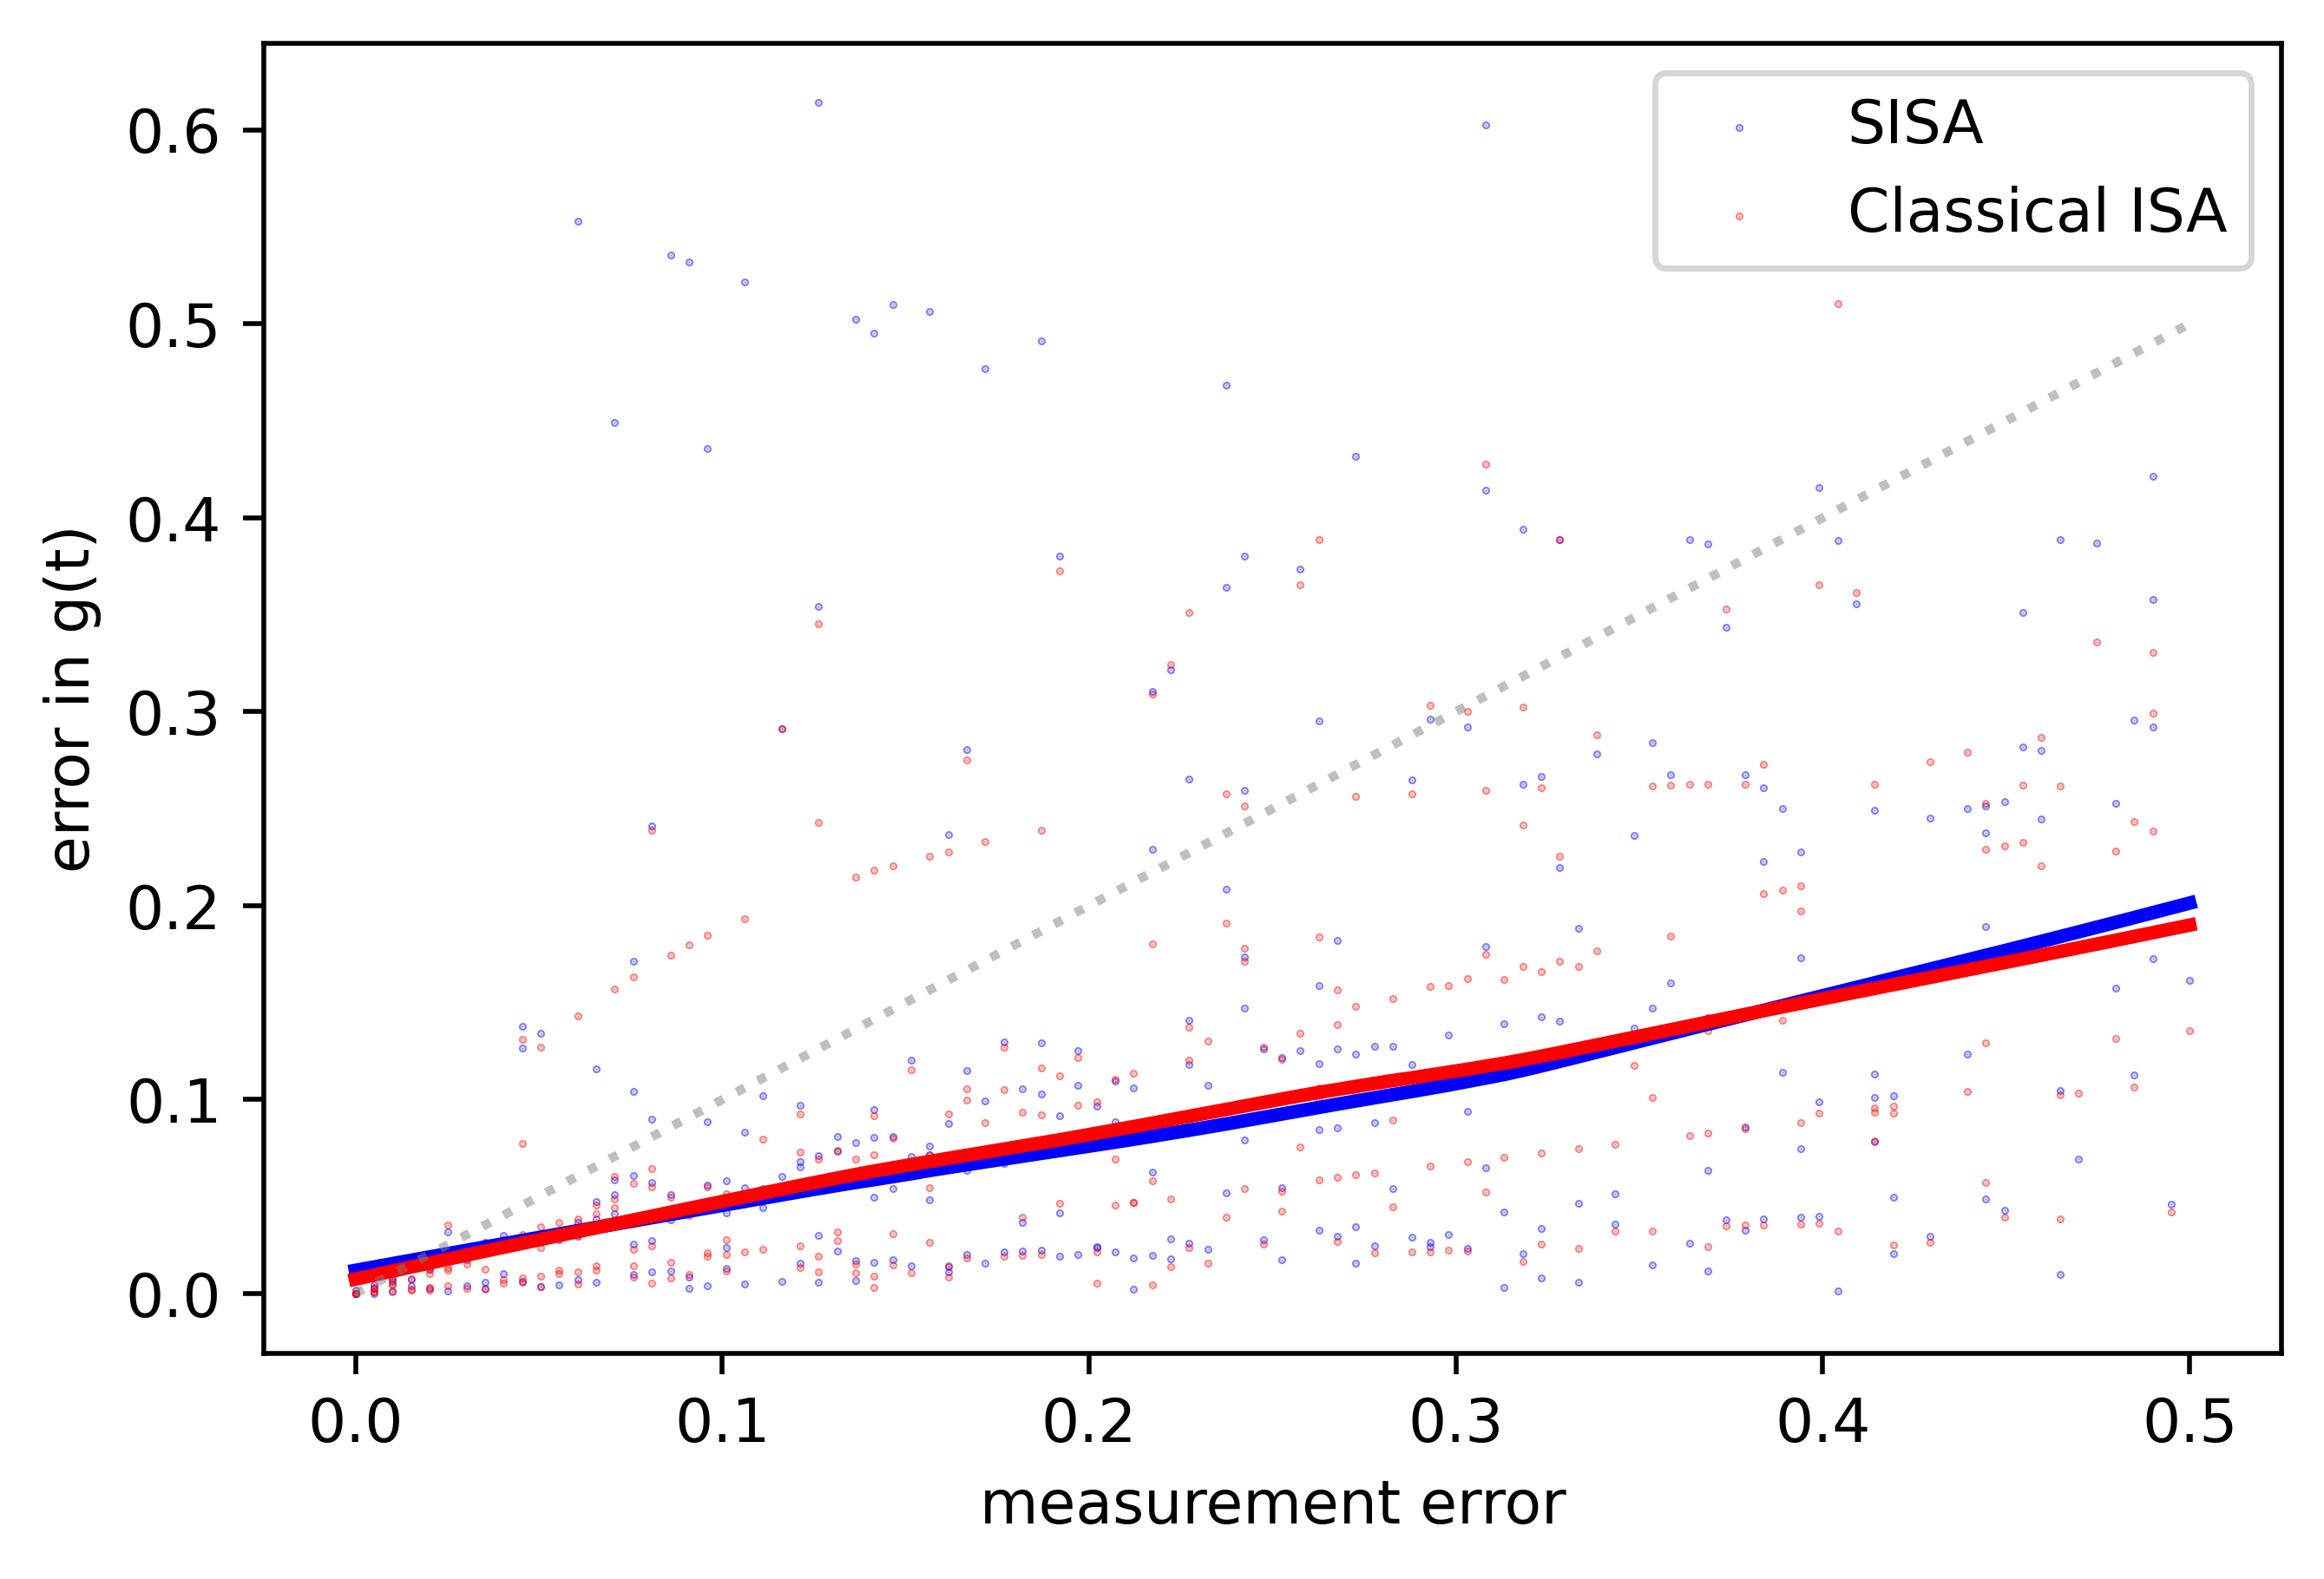

In [15]:
palette = {"SISA":"blue","Classical ISA":"red"}
models = {}
#sb.lineplot(data=plt_dict,x="measurement error",y="error in g(t)",hue="method",palette=palette)
for method,color in palette.items():
    filt = plt_dict[plt_dict["method"] == method]
    sb.regplot(data=plt_dict[plt_dict["method"] == method],x="measurement error",y="error in g(t)",lowess=True, ci=95,scatter_kws={"s": .1,"alpha":0.5},color=color,label=method)
    lowess = sm.nonparametric.lowess
    z = lowess(filt["error in g(t)"].values, filt["measurement error"].values,is_sorted=False)
    models[method] = interp1d(z[:,0],z[:,1])

plt.legend()
plt.plot(z[:,0],z[:,0],alpha=0.5,color="grey",linestyle=":")